In [ ]:
#pip install moviepy

In [21]:

import numpy as np
import pandas as pd
import time
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [22]:
df=pd.read_csv('forestfires.csv')

In [23]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [24]:
object_columns=df.select_dtypes(['object']).columns
df[object_columns]=df[object_columns].apply(lambda x: x.astype('category'))
cat_columns=df.select_dtypes(['category']).columns
df[cat_columns]=df[cat_columns].apply(lambda x: x.cat.codes)

In [25]:
df['area_log']= np.log(df.area +1)

In [26]:
df['area_bins'] = pd.qcut(df['area_log'],2, labels=[0,1])
df.drop(['area','area_log'],axis=1,inplace=True)

In [27]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area_bins
0,7,5,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
1,7,4,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
2,7,4,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
3,8,6,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
4,8,6,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0


In [28]:
y=df.pop('area_bins')
X=df

In [29]:
RS=123
tsne_3d = TSNE(perplexity=40,early_exaggeration= 40,n_iter=500,verbose=1,random_state=RS).fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 517 samples in 0.001s...
[t-SNE] Computed neighbors for 517 samples in 0.041s...
[t-SNE] Computed conditional probabilities for sample 517 / 517
[t-SNE] Mean sigma: 13.910009
[t-SNE] KL divergence after 250 iterations with early exaggeration: 266.269775
[t-SNE] KL divergence after 500 iterations: 1.088628


In [30]:
def scatter(x, colors):
    num_classes = len(np.unique(colors))
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", num_classes))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(num_classes):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 [Text(0.4238951, -1.5874201, '0'), Text(1.003047, -1.7327167, '1')])

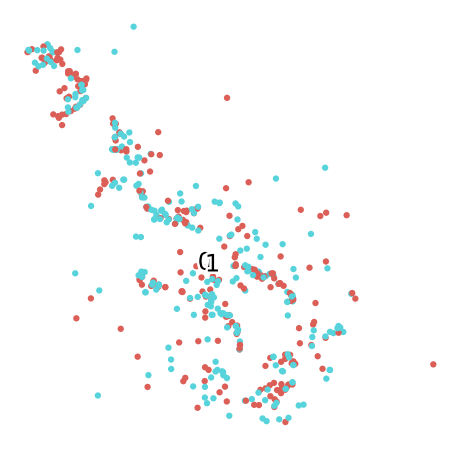

In [31]:
%matplotlib inline

scatter(tsne_3d, y)
#plt.savefig('digits_tsne-generated.png', dpi=120)

In [32]:
# This list will contain the positions of the map points at every iteration.
import sklearn
from scipy import linalg
positions = []
def _gradient_descent(objective, p0, it, n_iter,n_iter_check=1, n_iter_without_progress=30,momentum=0.5, learning_rate=1000.0, min_gain=0.01,min_grad_norm=1e-7, min_error_diff=1e-7, verbose=0,args=[],kwargs=None):
    # The documentation of this function can be found in scikit-learn's code.
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = 0

    for i in range(it, n_iter):
        # We save the current position.
        positions.append(p.copy())

        new_error, grad = objective(p, *args)
        error_diff = np.abs(new_error - error)
        error = new_error
        grad_norm = linalg.norm(grad)

        if error < best_error:
            best_error = error
            best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break
        if min_grad_norm >= grad_norm:
            break
        if min_error_diff >= error_diff:
            break

        inc = update * grad >= 0.0
        dec = np.invert(inc)
        gains[inc] += 0.05
        gains[dec] *= 0.95
        np.clip(gains, min_gain, np.inf)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

    return p, error, i


In [33]:
sklearn.manifold.t_sne._gradient_descent = _gradient_descent

X_proj = TSNE(perplexity=40,early_exaggeration= 40,n_iter=500,verbose=1,random_state=RS).fit_transform(X)
X_iter = np.dstack(position.reshape(-1, 2)
                   for position in positions)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 517 samples in 0.001s...
[t-SNE] Computed neighbors for 517 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 517 / 517
[t-SNE] Mean sigma: 13.910009
[t-SNE] KL divergence after 250 iterations with early exaggeration: 266.269775
[t-SNE] KL divergence after 500 iterations: 1.088628


t:   0%|          | 0/125 [00:00<?, ?it/s, now=None]

MoviePy - Building file tnse.gif with imageio.


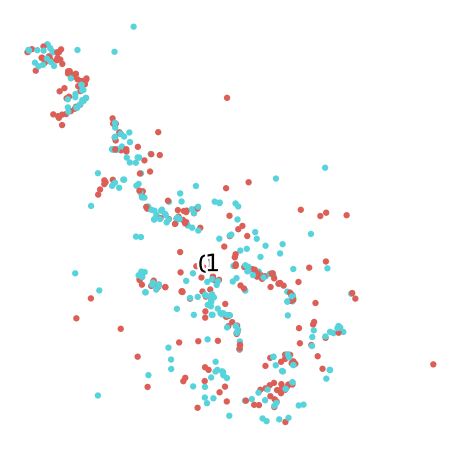

In [34]:
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

f, ax, sc, txts = scatter(X_iter[..., -1], y)

def make_frame_mpl(t):
    i = int(t*40)
    x = X_iter[..., i]
    sc.set_offsets(x)
    for j, txt in zip(range(10), txts):
        xtext, ytext = np.median(x[y == j, :], axis=0)
        txt.set_x(xtext)
        txt.set_y(ytext)
    return mplfig_to_npimage(f)

animation = mpy.VideoClip(make_frame_mpl,
                          duration=X_iter.shape[2]/40.)
animation.write_gif("tnse.gif", fps=10)